In [2]:
from DLtools.evaluation_rec import real_eva_error,list_eva_error
from DLtools.Data import del_less_col,check_specific_col,instant_data,intersection

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,LSTM,RepeatVector,TimeDistributed,Input,Dropout,Conv1D,MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)

In [3]:
def move_column_inplace(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)
    return df

In [4]:
def split_series(series, n_past, n_future):
    # n_past ==> no of past observations
    # n_future ==> no of future observations 
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [5]:
def record_result(y_train,y_test,trainPredict,testPredict,scaler_target,syn):
    global save_path,error
    global n_past,n_future,n_features,batch_size
    
    scale_Y = scaler_target.inverse_transform(y_train)
    scale_Yhat = scaler_target.inverse_transform(trainPredict.reshape(y_train.shape))
    scale_Y_t = scaler_target.inverse_transform(y_test)
    scale_Yhat_t = scaler_target.inverse_transform(testPredict.reshape(y_test.shape))



    mse, nse,r2 = list_eva_error(scale_Y, scale_Yhat,n_future)
    Tmse, Tnse,Tr2 = list_eva_error(scale_Y_t, scale_Yhat_t,n_future)

    for d in range(n_future):
        index = np.arange(len(y_train)+len(y_test))
        Y= pd.Series(data=scale_Y[:,d],index=index[:len(y_train)])
        Yhat = pd.Series(data=(scale_Yhat[:,d].ravel()),index=index[:len(y_train)])
        Y_t= pd.Series(data=scale_Y_t[:,d],index=index[-len(y_test):])
        Yhat_t = pd.Series(data=(scale_Yhat_t[:,d].ravel()),index=index[-len(y_test):])
        
        #Save fig only for day 1, day5,10,15...
        if ((d%6==0)):
            plt.figure(figsize=(15,5))
            plt.plot(Y, label = "Actual")
            plt.plot(Yhat, label = "Predict")
            
            plt.plot(Y_t, label = "Actual_test")
            plt.plot(Yhat_t, label = "Predict_test")
            plt.title('[{}] Day{}\n'.format(syn,d+1)+'Water Level CPY015 Forecast vs Actuals\n'+'Train MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (mse[d],nse[d],r2[d])+'\nTest  MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (Tmse[d],Tnse[d],Tr2[d]))
            plt.legend()
            # plt.savefig(save_path+'Plot_{}_d{}.png'.format(syn,d+1), dpi=300, bbox_inches='tight') 
            plt.show()

        
        _df = pd.DataFrame(["{}_{}d".format(syn,str(d+1)),n_features,n_past,batch_size,mse[d], nse[d],r2[d],Tmse[d], Tnse[d],Tr2[d]],index=idx,columns=[syn])
        error = pd.concat([error,_df],axis=1)
        #Note Fix path for error Record
        # error.to_csv('/home/song/Public/Song/Work/Thesis/output/Daily/eval.csv')

# Load input data

In [6]:
loading = instant_data()
df_d = loading.daily_instant()

* Interpolation limit 24 hours


Before del col are... 370
After... 189


<AxesSubplot:xlabel='date'>

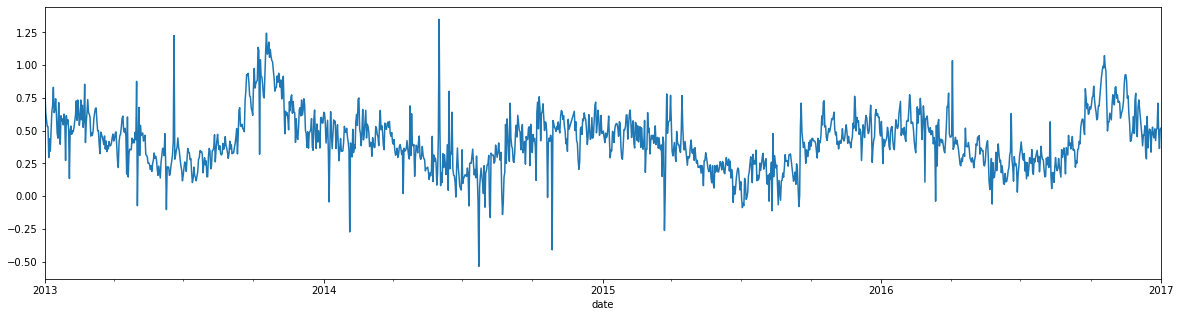

In [7]:
TARGET = 'CPY015_wl'
data = df_d['2013-01-01':'2017-01-01']
data = del_less_col(data,ratio=.85)
data['Day'] = data.index.dayofyear #add day

data = data.interpolate(limit=24).apply(lambda x: x.fillna(x.mean()),axis=0).astype('float32')#interpolate neighbor first, for rest NA fill with mean()
data[TARGET].plot(figsize=(20,5))

# MARS feature selection

In [8]:
# mar = pd.read_csv('/home/song/Public/Song/Work/Thesis/featurelist_MAR_Day_ahead7d.csv')
# col = [i for i in data.columns]
# select_col = intersection(col,mar['feature'])
# select_col.append(TARGET) # add target
# data = data[select_col]

# Setting Parameter, savefile

In [9]:
###### SETTING ################
n_past = 30
n_future = 7
n_features = len(data.columns)

#load previous error rec
idx=['Modelname','Feature','n_in_time','batchsize','mse','nse','r2','Test_mse','Test_nse','Test_r2']

try: error = pd.read_csv('/home/song/Public/Song/Work/Thesis/output/Daily/eval.csv',index_col=False)
except: error = pd.DataFrame(index = idx)

##Save path
save_path = '/home/song/Public/Song/Work/Thesis/output/Daily/DL/'
#####################

In [10]:
# Move Y to first row
data = move_column_inplace(data,TARGET,0)
# SCALE
scaler_tar = MinMaxScaler()
scaler_tar.fit(data[TARGET].to_numpy().reshape(-1,1))
scaler = MinMaxScaler()
data[data.columns] = scaler.fit_transform(data[data.columns])

# Train-Test split
split_pt = int(data.shape[0]*.7)
train,test = data.iloc[:split_pt,:],data.iloc[split_pt:,:]

#Split XY
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train[:,:,0]
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test[:,:,0]

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(987, 30, 190) (987, 7)
(403, 30, 190) (403, 7)


# Customer loss fucntion

In [30]:
# import keras.backend as K
# def custom_nse(y_true, y_pred):
#     s, e =  y_true,y_pred
#     mean_observed = K.mean(e)
#     # compute numerator and denominator
#     numerator = K.sum((e - s) ** 2)
#     denominator = K.sum((e - mean_observed)**2)
#     # compute coefficient
#     return 1 - (numerator / denominator)


# Automatation loop

In [11]:
callback_early_stopping = EarlyStopping(monitor='val_loss',patience=7, verbose=2)
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
callbacks = [callback_early_stopping,reduce_lr]

In [12]:
def build_lstm():
    global n_past,n_future,n_features
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_past, n_features),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(200, activation='relu', return_sequences=False))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_future))
    model.compile(loss='huber_loss', optimizer='adam')
    model.summary()
    return model

def build_ende_lstm():
    global n_past,n_future,n_features
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_past, n_features)))
    model.add(RepeatVector(n_future))                                  # Decoder 
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

def build_cnn1d():
    global n_past,n_future,n_features
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_past, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(n_future))
    model.compile(optimizer='adam', loss='mse')
    return model

In [13]:
def run_code(model,batch_size,syn):
    verbose, epochs = 1, 70
    # n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

    history = model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=batch_size,verbose=verbose,callbacks=callbacks)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.savefig(save_path+'loss_{}.png'.format(syn), dpi=300, bbox_inches='tight') 
    plt.show()
    
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)
    record_result(y_train,y_test,trainPredict,testPredict,scaler_tar,syn)

    print('Done')

Epoch 1/100
8/8 [==============================] - 0s 59ms/step - loss: 0.2344 - val_loss: 0.0323 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0490 - val_loss: 0.0248 - lr: 9.0000e-04
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0322 - val_loss: 0.0190 - lr: 8.1000e-04
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0256 - val_loss: 0.0175 - lr: 7.2900e-04
Epoch 5/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0208 - val_loss: 0.0146 - lr: 6.5610e-04
Epoch 6/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0180 - val_loss: 0.0132 - lr: 5.9049e-04
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0166 - val_loss: 0.0128 - lr: 5.3144e-04
Epoch 8/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0151 - val_loss: 0.0123 - lr: 4.7830e-04
Epoch 9/100
8/8 [==============================] - 0s 30ms/step - loss: 0.0145 - val

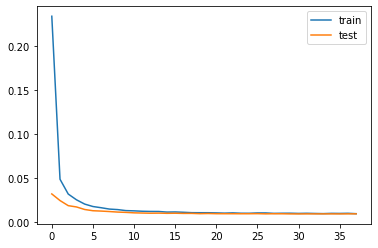

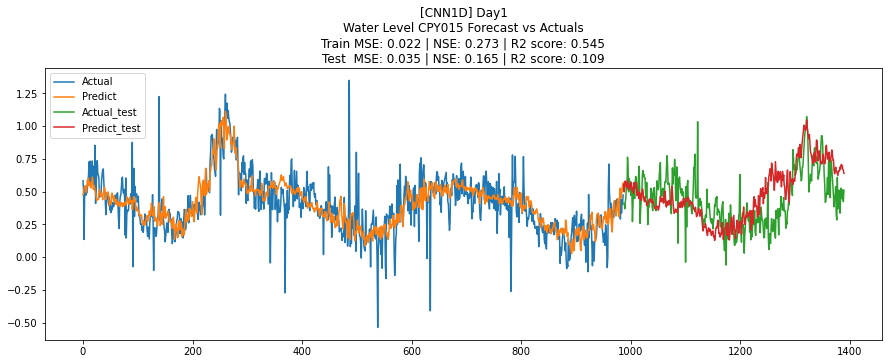

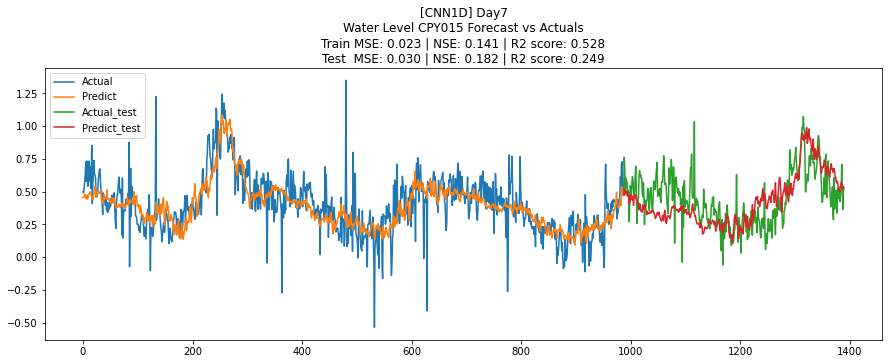

Done


In [17]:
batch_size = 128
model = run_code(build_cnn1d(),batch_size,'CNN1D')

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 30, 200)           277600    
_________________________________________________________________
dropout_28 (Dropout)         (None, 30, 200)           0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_38 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_29 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 7)                 707       
Total params: 619,207
Trainable params: 619,207
Non-trainable params: 0
_______________________________________________

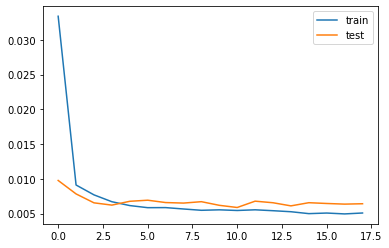

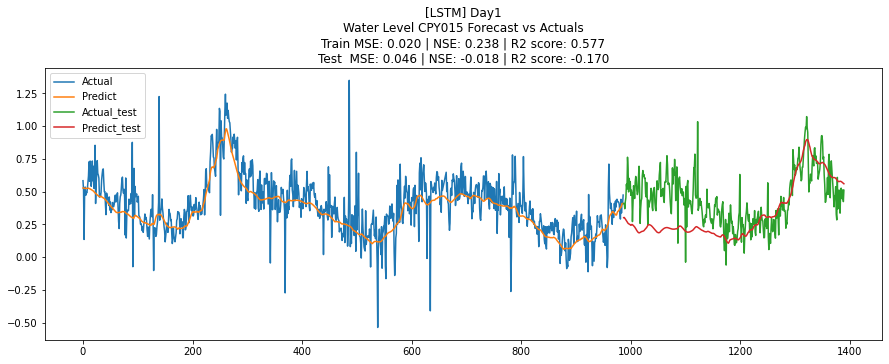

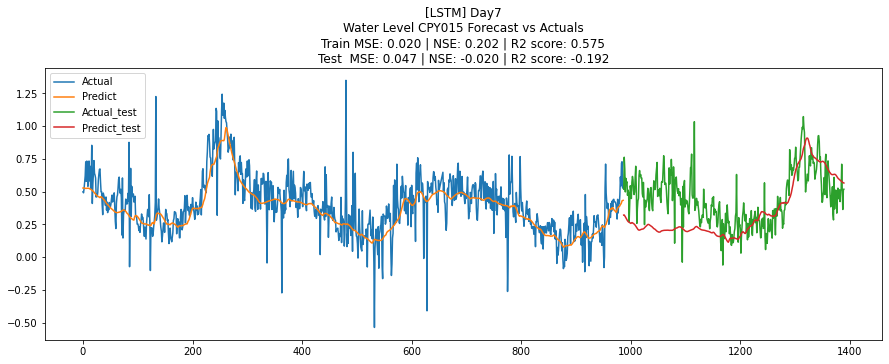

Done


In [69]:
run_code(build_lstm(),batch_size,'LSTM')

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 200)               277600    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 7, 200)            0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 7, 200)            320800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 7, 1)              101       
Total params: 618,601
Trainable params: 618,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 3s 366ms/step - loss: 0.1136 - val_loss: 0.0606 - lr: 0.0010
E

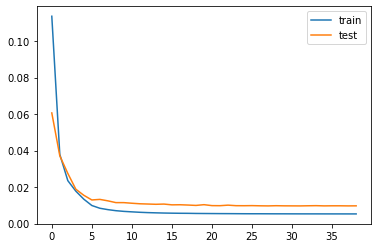

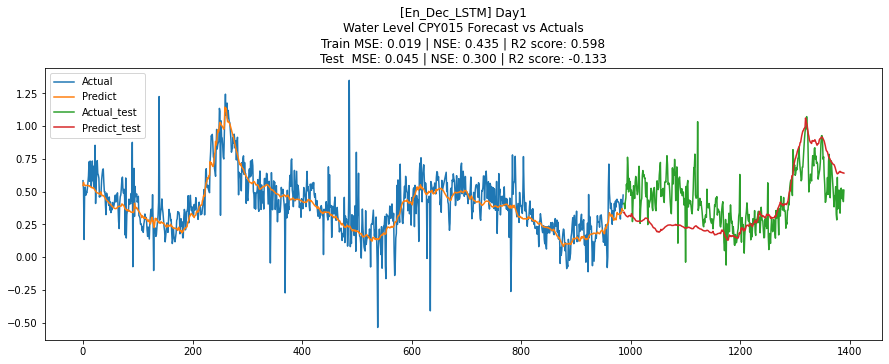

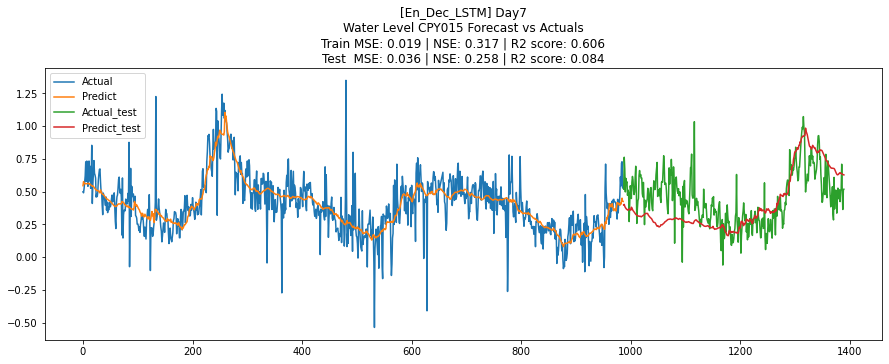

Done


In [63]:
run_code(build_ende_lstm(),batch_size,'En_Dec_LSTM')

# Detail stepbystep

In [72]:
# verbose, epochs, batch_size = 1, 70, 128
# n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# model = build_
# history = model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=batch_size,verbose=verbose,callbacks=callbacks)
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()

# plt.show()

# Plot prediction

In [18]:
# get prdict result as once
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

record_result(y_train,y_test,trainPredict,testPredict,scaler_tar,save_path,'hourly_2layer_Lstm')

AttributeError: 'NoneType' object has no attribute 'predict'

In [71]:
# plt.figure(figsize=(20,5))
# plt.plot(y_test[-500:,1],label='Y')
# plt.plot(testPredict[-500:,1],label='Yhat')
# plt.legend()

# Extra

In [68]:
# ###### SEQ_SEQ
# verbose, epochs, batch_size = 1, 70, 16

# n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# # define model
# model = Sequential()
# model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
# model.add(RepeatVector(n_outputs))                                  # Decoder 
# model.add(LSTM(200, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(100, activation='relu')))
# model.add(TimeDistributed(Dense(1)))
# model.compile(loss='mse', optimizer='adam')
# model.summary()

# history = model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=batch_size,verbose=verbose,callbacks=callbacks)

# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show()

In [ ]:
# # define model
# model = Sequential()
# model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
# model.add(RepeatVector(n_outputs))                                  # Decoder 
# model.add(LSTM(200, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(100, activation='relu')))
# odel.add(TimeDistributed(Dense(1)))
# model.compile(loss='mse', optimizer='adam')
# model.summary()

# # # LSTM
# model = Sequential()
# # model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
# model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features),return_sequences=True))
# model.add(LSTM(200, activation='relu', return_sequences=False))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(n_outputs))
# model.compile(loss='mse', optimizer='adam')
# model.summary()


#### CNN 1D [Workbest]
# model = Sequential()
# model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_timesteps, n_features)))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dropout(0.3))
# model.add(Dense(50, activation='relu'))
# model.add(Dense(n_outputs))
# model.compile(optimizer='adam', loss='mse')

# # MOD [Dropout + LSTM] define model
# model = Sequential()
# model.add(LSTM(128*3, activation='relu', input_shape=(n_timesteps, n_features)))
# model.add(RepeatVector(n_outputs))                                  # Decoder 
# model.add(LSTM(200, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(100, activation='relu')))
# model.add(Dropout(0.2))
# model.add(TimeDistributed(Dense(1)))
# model.compile(loss='mse', optimizer='adam')
# model.summary()